# Modeling - Transfer Learning

The idea of transfer learning was shaped by the learning paradigm of human. People have an inherent ability to transfer knowledge across tasks. We use the knowledge we learn in one job in another job, so transfer learning in deep learning was inspired by this motivation.
Transfer learning is the reuse of a model that has previously learned for another problem on a new problem. 
A model uses the knowledge learned from a previous problem to increase prediction about a new problem. 

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import random
import os
from pathlib import Path
from tensorflow.keras.applications import ResNet50, Xception, InceptionV3
import ssl

ssl._create_default_https_context = ssl._create_unverified_context # for downloading weights

In [2]:
df = pd.read_csv("../data/train.csv")

### Constants

In [3]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE=15
EPOCHS = 25

### Train Validation Split 

In [4]:
train_df, validation_df = train_test_split(df, test_size=0.20, stratify=df["lession_type"], random_state=99)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

## Data Augmentation

### Train Image Generator

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='image_path',
    y_col='lession_type',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 6409 validated image filenames belonging to 7 classes.


### Validation Generator

In [6]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    x_col='image_path',
    y_col='lession_type',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 1603 validated image filenames belonging to 7 classes.


In [7]:
total_train = train_df.shape[0]
total_validate = validation_df.shape[0]

## Resnet50

### Callbacks

In [8]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2,verbose=1,factor=0.5, min_lr=0.00001)
path_weights = Path( '../data/weights/resnet50' )
path_weights.mkdir( parents=True, exist_ok=True ) # create a folder for model checkpoints

filepath= os.path.join(path_weights,"model_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks = [earlystop, learning_rate_reduction, checkpoint]

### Build Model

In [9]:
#ResNet50

base_model = ResNet50(weights='imagenet', 
                                include_top=False, 
                                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(base_model.input, predictions)

# Compile it
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

2021-12-30 07:40:14.313289: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-30 07:40:16.134579: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
427/427 [==============================] - 648s 2s/step - loss: 1.2386 - acc: 0.6520 - val_loss: 1.1388 - val_acc: 0.6698

Epoch 00001: val_acc improved from -inf to 0.66981, saving model to ../data/weights/resnet50/model_best.hdf5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/25
427/427 [==============================] - 647s 2s/step - loss: 1.1666 - acc: 0.6692 - val_loss: 1.1308 - val_acc: 0.6723

Epoch 00002: val_acc improved from 0.66981 to 0.67233, saving model to ../data/weights/resnet50/model_best.hdf5
Epoch 3/25
427/427 [==============================] - 647s 2s/step - loss: 1.1593 - acc: 0.6694 - val_loss: 1.1174 - val_acc: 0.6711

Epoch 00003: val_acc did not improve from 0.67233
Epoch 4/25
427/427 [==============================] - 648s 2s/step - loss: 1.1513 - acc: 0.6694 - val_loss: 1.1335 - val_acc: 0.6673

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_acc did not improve from 0.67233
Epoch 5/25
427/427 [==============================] - 653s 2s/step - loss: 1.1350 - acc: 0.6702 - val_loss: 1.1051 - val_acc: 0.6711

Epoch 00005: val_acc did not improve from 0.67233
Epoch 6/25
427/427 [==============================] - 664s 2s/step - loss: 1.1306 - acc: 0.6695 - val_loss: 1.1062 - val_

### Export Model

In [11]:
model.save('../data/weights/resnet50/model_latest.hdf5')

### Visualize Result

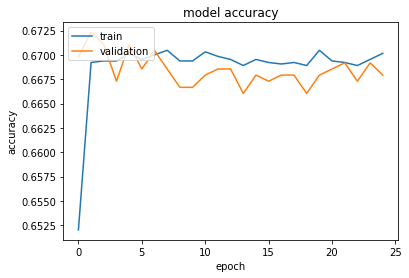

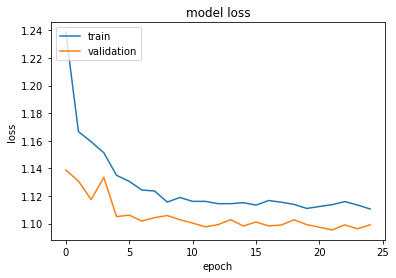

In [12]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../graphs/resnet50_model_accuracy_plot.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../graphs/resnet50_model_loss_plot.png')
plt.show()

## Xception

### Callbacks

In [13]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2,verbose=1,factor=0.5, min_lr=0.00001)
path_weights = Path( '../data/weights/xception' )
path_weights.mkdir( parents=True, exist_ok=True ) # create a folder for model checkpoints

filepath= os.path.join(path_weights,"model_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks = [earlystop, learning_rate_reduction, checkpoint]

### Build Model

In [14]:
# Xception

base_model = Xception(weights='imagenet', 
                                include_top=False, 
                                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(base_model.input, predictions)

# Compile it
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

83697664/83683744 [==============================] - 12s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

### Train

In [15]:
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/25
427/427 [==============================] - 887s 2s/step - loss: 0.9859 - acc: 0.6758 - val_loss: 0.8722 - val_acc: 0.7038

Epoch 00001: val_acc improved from -inf to 0.70377, saving model to ../data/weights/xception/model_best.hdf5
Epoch 2/25
427/427 [==============================] - 902s 2s/step - loss: 0.8808 - acc: 0.6917 - val_loss: 0.8263 - val_acc: 0.7088

Epoch 00002: val_acc improved from 0.70377 to 0.70881, saving model to ../data/weights/xception/model_best.hdf5
Epoch 3/25
427/427 [==============================] - 866s 2s/step - loss: 0.8160 - acc: 0.7052 - val_loss: 0.8007 - val_acc: 0.7138

Epoch 00003: val_acc improved from 0.70881 to 0.71384, saving model to ../data/weights/xception/model_best.hdf5
Epoch 4/25
427/427 [==============================] - 882s 2s/step - loss: 0.8170 - acc: 0.7157 - val_loss: 0.7981 - val_acc: 0.7088

Epoch 00004: val_acc did not improve from 0.71384
Epoch 5/25
427/427 [==============================] - 795s 2s/step - loss: 0.8076

### Export Model

In [16]:
model.save('../data/weights/xception/model_latest.hdf5')

### Visualize Result

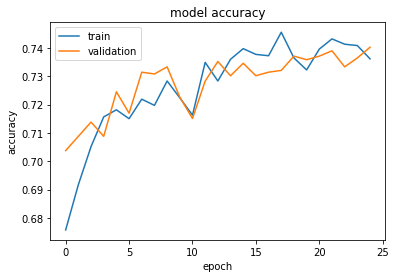

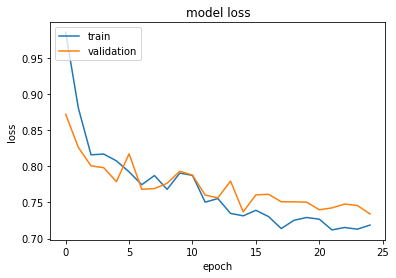

In [17]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../graphs/xception_model_accuracy_plot.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../graphs/xception_model_loss_plot.png')
plt.show()

## InceptionV3

### Callbacks

In [18]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2,verbose=1,factor=0.5, min_lr=0.00001)
path_weights = Path( '../data/weights/inceptionv3' )
path_weights.mkdir( parents=True, exist_ok=True ) # create a folder for model checkpoints

filepath= os.path.join(path_weights,"model_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks = [earlystop, learning_rate_reduction, checkpoint]

### Build Model

In [19]:
# InceptionV3

base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(base_model.input, predictions)

# Compile it
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

87924736/87910968 [==============================] - 8s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 111, 111, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_4[0][0]      
___________________________

### Train

In [20]:
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/25
427/427 [==============================] - 462s 1s/step - loss: 1.1135 - acc: 0.6550 - val_loss: 0.8511 - val_acc: 0.7170

Epoch 00001: val_acc improved from -inf to 0.71698, saving model to ../data/weights/inceptionv3/model_best.hdf5
Epoch 2/25
427/427 [==============================] - 448s 1s/step - loss: 0.9221 - acc: 0.6985 - val_loss: 0.7560 - val_acc: 0.7296

Epoch 00002: val_acc improved from 0.71698 to 0.72956, saving model to ../data/weights/inceptionv3/model_best.hdf5
Epoch 3/25
427/427 [==============================] - 455s 1s/step - loss: 0.9168 - acc: 0.6891 - val_loss: 0.7455 - val_acc: 0.7352

Epoch 00003: val_acc improved from 0.72956 to 0.73522, saving model to ../data/weights/inceptionv3/model_best.hdf5
Epoch 4/25
427/427 [==============================] - 456s 1s/step - loss: 0.8979 - acc: 0.7016 - val_loss: 0.7649 - val_acc: 0.7245

Epoch 00004: val_acc did not improve from 0.73522
Epoch 5/25
427/427 [==============================] - 467s 1s/step - los

### Export Model

In [21]:
model.save('../data/weights/inceptionv3/model_latest.hdf5')

### Visualize Result

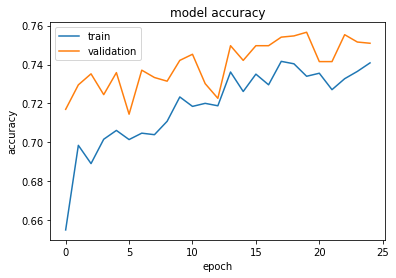

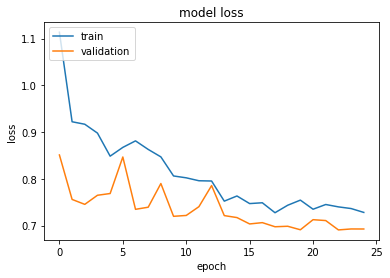

In [22]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../graphs/inceptionv3_model_accuracy_plot.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../graphs/inceptionv3_model_loss_plot.png')
plt.show()